In [ ]:
# Import and Install

In [ ]:
! pip install -r requirements.txt

  Cloning https://github.com/huggingface/accelerate.git to /tmp/pip-install-9xioj6bk/accelerate_e07364508c1e48daa9fb3c9698759d3e
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate.git /tmp/pip-install-9xioj6bk/accelerate_e07364508c1e48daa9fb3c9698759d3e
  Resolved https://github.com/huggingface/accelerate.git to commit ceb7c699bc36bdb3bbf32cceaaca2d1ceaf62dae
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-install-9xioj6bk/transformers_dd1a718814814f79a5f4aff58cf1e3ea
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-install-9xioj6bk/transformers_dd1a718814814f79a5f4aff58cf1e3ea
  Resolved https://github.com/huggingface/transformers.git to commit 29e7a1e1834f331a4916853ecd58549ed78235d6
  Installing build dependencies ... don

In [ ]:
%%capture
! pip install datasets

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00


In [ ]:
import wandb
import random
import pandas as pd

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
# Import libraries
import argparse
import bitsandbytes as bnb
from datasets import load_dataset
from functools import partial
import os
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, AutoPeftModelForCausalLM
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed, Trainer, TrainingArguments, BitsAndBytesConfig, \
    DataCollatorForLanguageModeling, Trainer, TrainingArguments
from datasets import load_dataset

In [ ]:
import random

In [ ]:
# Global Variables
seed = 42 # Reproducibility
random.seed(seed)

BATCH_SIZE = 4


In [ ]:
# Dataset loading and preprocessing

In [ ]:
# from datasets import get_dataset_split_names
from sklearn.model_selection import train_test_split

# get_dataset_split_names("jawerty/html_dataset")

In [ ]:
data = load_dataset('jawerty/html_dataset', split="train")
train_dataset, eval_dataset = train_test_split(data, test_size=0.2)


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/jawerty___json/jawerty--html_dataset-172371c389c824ca/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96. Subsequent calls will reuse this data.


<div class="main-wrapper" role="main">
    <div class="main-content">
        <h1 class="zone-name-title h1">
            
            www.doordash.com
        </h1>
        <h2 class="h2" id="challenge-running">Checking if the site connection is secure</h2><div id="challenge-stage" style="display: none;"></div><div id="challenge-spinner" class="spacer loading-spinner" style="display: block; visibility: visible;"><div class="lds-ring"><div></div><div></div><div></div><div></div></div></div>
        <noscript>
            <div id="challenge-error-title">
                <div class="h2">
                    <span class="icon-wrapper">
                        <div class="heading-icon warning-icon"></div>
                    </span>
                    <span id="challenge-error-text">
                        Enable JavaScript and cookies to continue
                    </span>
                </div>
            </div>
        </noscript>
        <div id="trk_jschal_js" style="display:none;
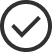

In [ ]:
print(train_dataset["html"][0])

In [ ]:
print(train_dataset["label"][0])

this is a colorful landing page with a search bar


In [ ]:
len(train_dataset["html"])

34

In [ ]:
def create_html_prompt(row):
  return ("Below is an instruction that describes a task. "
            "You will be provided a prompt and based on it you have to generate HTML code. Write a response that appropriately completes the request.\n\n"
            "### Instruction:\n{}\n\n### Response:\n").format(row)

In [ ]:
train_prompts = [create_html_prompt(row) for row in train_dataset["label"]]
eval_prompts = [create_html_prompt(row) for row in eval_dataset["label"]]

We need to process the targets and add the End Of String token (EOS) to the results. For LLama this is: `"</s>"`

In [ ]:
def pad_eos(ds):
    EOS_TOKEN = "</s>"
    return [f"{row}{EOS_TOKEN}" for row in ds]

In [ ]:
train_outputs = pad_eos(train_dataset["html"])
eval_outputs = pad_eos(eval_dataset["html"])

In [ ]:
train_dataset = [{"prompt":s, "output":t, "example": s + t} for s, t in zip(train_prompts, train_outputs)]
eval_dataset = [{"prompt":s, "output":t, "example": s + t} for s, t in zip(eval_prompts, eval_outputs)]

In [ ]:
train_dataset[0]["prompt"]

'Below is an instruction that describes a task. You will be provided a prompt and based on it you have to generate HTML code. Write a response that appropriately completes the request.\n\n### Instruction:\na minimalist login page\n\n### Response:\n'

In [ ]:
train_dataset[0]["output"]

'<div id="__next"><div class="np-theme-light"><div class="main-wrapper main-us grid--xl"><div class="BasePage_navContainer__AXGx5"><div class="tw-public-nav-background public-navigation-wrapper"><div class="Navigation_navContainer__T_Oea"><a href="#main" class="btn btn-primary tw-public-nav-btn-skip">Skip to main content</a><header class="tw-public-nav tw-public-nav--en_US Navigation_nav__gPzzv" data-tracking-id="public-navigation"><div class="tw-public-nav__grid container"><div class="tw-public-nav__header"><button class="tw-public-nav__menu-toggle tw-public-nav__menu-toggle--open is-collapsed" aria-controls="navbar" aria-expanded="false" type="button" aria-label="Toggle navigation"><span class="tw-icon tw-icon-menu " aria-hidden="true" role="presentation" data-testid="menu-icon"><svg width="24" height="24" fill="currentColor" focusable="false" viewBox="0 0 24 24"><path fill-rule="evenodd" clip-rule="evenodd" d="M19.714 6.004H4.286v1.714h15.428V6.004Zm0 5.144H4.286v1.715h15.428v-1.715

In [ ]:
train_dataset[0]["example"]

'Below is an instruction that describes a task. You will be provided a prompt and based on it you have to generate HTML code. Write a response that appropriately completes the request.\n\n### Instruction:\nthis is a landing page\n\n### Response:\n<div id="__next"><div class="np-theme-light"><div class="main-wrapper main-us grid--xl"><div class="BasePage_navContainer__AXGx5"><div class="tw-public-nav-background public-navigation-wrapper"><div class="Navigation_navContainer__T_Oea"><a href="#main" class="btn btn-primary tw-public-nav-btn-skip">Skip to main content</a><header class="tw-public-nav tw-public-nav--en_US Navigation_nav__gPzzv" data-tracking-id="public-navigation"><div class="tw-public-nav__grid container"><div class="tw-public-nav__header"><button class="tw-public-nav__menu-toggle tw-public-nav__menu-toggle--open is-collapsed" aria-controls="navbar" aria-expanded="false" type="button" aria-label="Toggle navigation"><span class="tw-icon tw-icon-menu " aria-hidden="true" role="

In [ ]:
# tokenization

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
model_id = 'meta-llama/Llama-2-7b-hf'
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
# Packing
"""The main idea here is that the instruction/output samples are short,
so let's concatenate a bunch of them together separated by the `EOS` token.
We can also pre-tokenize and pre-pack the dataset and make everything faster!
If we define a `max_seq_len = 1024` the code to pack would look something like this:"""

"The main idea here is that the instruction/output samples are short,\nso let's concatenate a bunch of them together separated by the `EOS` token.\nWe can also pre-tokenize and pre-pack the dataset and make everything faster!\nIf we define a `max_seq_len = 1024` the code to pack would look something like this:"

In [ ]:
max_sequence_len = 1024

def pack(dataset, max_seq_len=max_sequence_len):
    tkds_ids = tokenizer([s["example"] for s in dataset])["input_ids"]

    all_token_ids = []
    for tokenized_input in tkds_ids:
        all_token_ids.extend(tokenized_input)# + [tokenizer.eos_token_id])

    print(f"Total number of tokens: {len(all_token_ids)}")
    packed_ds = []
    for i in range(0, len(all_token_ids), max_seq_len+1):
        input_ids = all_token_ids[i : i + max_seq_len+1]
        if len(input_ids) == (max_seq_len+1):
            packed_ds.append({"input_ids": input_ids[:-1], "labels": input_ids[1:]})  # this shift is not needed if using the model.loss
    return packed_ds

In [ ]:
train_ds_packed = pack(train_dataset)
eval_ds_packed = pack(eval_dataset)
len(train_ds_packed)

Total number of tokens: 1026783
Total number of tokens: 136771


1001

### DataLoader

In [ ]:
from torch.utils.data import DataLoader
from transformers import default_data_collator
from transformers import DataCollatorForLanguageModeling

torch.manual_seed(seed)
# batch_size = BATCH_SIZE
collate_fn = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

train_dataloader = DataLoader(
    train_ds_packed,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
)

eval_dataloader = DataLoader(
    eval_ds_packed,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    shuffle=False,
)

In [ ]:
b = next(iter(train_dataloader))
b

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': tensor([[    1, 13866,   338,  ...,  1636, 29889, 29893],
        [29889,   990, 29914,  ...,  8569,   519,   543],
        [29908,  6297,   543,  ..., 29936,  2602, 29901],
        [29936,  2175, 29901,  ...,  1543,   272, 29899]]), 'labels': tensor([[    1, 13866,   338,  ...,  1636, 29889, 29893],
        [29889,   990, 29914,  ...,  8569,   519,   543],
        [29908,  6297,   543,  ..., 29936,  2602, 29901],
        [29936,  2175, 29901,  ...,  1543,   272, 29899]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])}

In [ ]:
# Model preparation

### Model Configuration

In [ ]:
# General Configuration
from types import SimpleNamespace

gradient_accumulation_steps = 4

config = SimpleNamespace(
    lr=2e-4,
    n_eval_samples=10, # How many samples to generate on validation
    max_seq_len=max_sequence_len, # Lenght of the sequences to pack
    epochs=3,  # we do 3 pasess over the dataset.
    gradient_accumulation_steps=gradient_accumulation_steps,  # evey how many iterations we update the gradients, simulates larger batch sizes
    batch_size=BATCH_SIZE,  # what my GPU can handle, depends on how many layers are we training
    log_model=False,  # upload the model to W&B?
    gradient_checkpointing = True,  # saves even more memory
    freeze_embed = True,  # why train this? let's keep them frozen ❄️
    seed=seed,
)

config.total_train_steps = config.epochs * len(train_dataloader) // config.gradient_accumulation_steps

In [ ]:
# Quantization Config
def create_bnb_config():
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )

    return bnb_config

In [ ]:
# LoRA Config
def create_peft_config(modules):
    """
    Create Parameter-Efficient Fine-Tuning config for your model
    :param modules: Names of the modules to apply Lora to
    """
    config = LoraConfig(
        r=16,  # dimension of the updated matrices
        lora_alpha=64,  # parameter for scaling
        target_modules=modules,
        lora_dropout=0.1,  # dropout probability for layers
        bias="none",
        task_type="CAUSAL_LM",
    )

    return config

In [ ]:
# SOURCE https://github.com/artidoro/qlora/blob/main/qlora.py
def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit #if args.bits == 4 else (bnb.nn.Linear8bitLt if args.bits == 8 else torch.nn.Linear)
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:  # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

In [ ]:
def print_trainable_parameters(model, use_4bit=False):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        num_params = param.numel()
        # if using DS Zero 3 and the weights are initialized empty
        if num_params == 0 and hasattr(param, "ds_numel"):
            num_params = param.ds_numel

        all_param += num_params
        if param.requires_grad:
            trainable_params += num_params
    if use_4bit:
        trainable_params /= 2
    print(
        f"all params: {all_param:,d} || trainable params: {trainable_params:,d} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
def load_model(model_name, bnb_config):
    n_gpus = torch.cuda.device_count()
    max_memory = f'{40960}MB'

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto", # dispatch efficiently the model on the available ressources
        max_memory = {i: max_memory for i in range(n_gpus)},
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)

    # Needed for LLaMA tokenizer
    tokenizer.pad_token = tokenizer.eos_token

    return model, tokenizer

In [ ]:
# Load model from HF with user's token and with bitsandbytes config
model_name = "meta-llama/Llama-2-7b-hf"
bnb_config = create_bnb_config()
model, tokenizer = load_model(model_name, bnb_config)

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:691: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
# Apply preprocessing to the model to prepare it by
# 1 - Enabling gradient checkpointing to reduce memory usage during fine-tuning
model.gradient_checkpointing_enable()

# 2 - Using the prepare_model_for_kbit_training method from PEFT
model = prepare_model_for_kbit_training(model)

# Get lora module names
modules = find_all_linear_names(model)

# Create PEFT config for these modules and wrap the model to PEFT
peft_config = create_peft_config(modules)
model = get_peft_model(model, peft_config)

# Print information about the percentage of trainable parameters
print_trainable_parameters(model)

all params: 3,540,389,888 || trainable params: 39,976,960 || trainable%: 1.1291682911958425


In [ ]:
# Optimizer
from transformers import get_cosine_schedule_with_warmup


# optim = torch.optim.Adam(model.parameters(), lr=config.lr, betas=(0.9,0.99), eps=1e-5)
optim = bnb.optim.Adam8bit(model.parameters(), lr=config.lr, betas=(0.9,0.99), eps=1e-5)
scheduler = get_cosine_schedule_with_warmup(
    optim,
    num_training_steps=config.total_train_steps,
    num_warmup_steps=config.total_train_steps // 10,
)

In [ ]:
# Loss Function
def loss_fn(x, y):
    "A Flat CrossEntropy"
    return torch.nn.functional.cross_entropy(x.view(-1, x.shape[-1]), y.view(-1))

In [ ]:
# Training

In [ ]:
import wandb
from tqdm.auto import tqdm

def to_gpu(tensor_dict):
    return {k: v.to('cuda') for k, v in tensor_dict.items()}

class Accuracy:
    "A simple Accuracy function compatible with HF models"
    def __init__(self):
        self.count = 0
        self.tp = 0.
    def update(self, logits, labels):
        logits, labels = logits.argmax(dim=-1).view(-1).cpu(), labels.view(-1).cpu()
        tp = (logits == labels).sum()
        self.count += len(logits)
        self.tp += tp
        return tp / len(logits)
    def compute(self):
        return self.tp / self.count

In [ ]:
# Validation
@torch.no_grad()
def validate():
    model.eval();
    eval_acc = Accuracy()
    loss, total_steps = 0., 0
    for step, batch in enumerate(pbar:=tqdm(eval_dataloader, leave=False)):
        pbar.set_description(f"doing validation")
        batch = to_gpu(batch)
        total_steps += 1
        with torch.amp.autocast("cuda", dtype=torch.float16):
            out = model(**batch)
            loss += loss_fn(out.logits, batch["labels"])  # you could use out.loss and not shift the dataset
        eval_acc.update(out.logits, batch["labels"])
    # we log results at the end
    wandb.log({"eval/loss": loss.item() / total_steps,
               "eval/accuracy": eval_acc.compute()})
    # prompt_table(eval_dataset[:config.n_eval_samples], log=True)
    model.train();

In [ ]:
# Save Model
from pathlib import Path
def save_model(model, model_name, models_folder="models", log=False):
    """Save the model to wandb as an artifact
    Args:
        model (nn.Module): Model to save.
        model_name (str): Name of the model.
        models_folder (str, optional): Folder to save the model. Defaults to "models".
    """
    model_name = f"{wandb.run.id}_{model_name}"
    file_name = Path(f"{models_folder}/{model_name}")
    file_name.parent.mkdir(parents=True, exist_ok=True)
    model.save_pretrained(file_name, safe_serialization=True)
    # save tokenizer for easy inference
    tokenizer = AutoTokenizer.from_pretrained(model.name_or_path)
    tokenizer.save_pretrained(model_name)
    if log:
        at = wandb.Artifact(model_name, type="model")
        at.add_dir(file_name)
        wandb.log_artifact(at)

In [ ]:
# Training Loop

In [ ]:
wandb.init(project="html-generation", # the project I am working on
           tags=["baseline","7b"],
           job_type="train",
           config=config) # the Hyperparameters I want to keep track of

# Training
acc = Accuracy()
model.train()
train_step = 0
for epoch in tqdm(range(config.epochs)):
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = to_gpu(batch)
        with torch.amp.autocast("cuda", dtype=torch.float16):
            out = model(**batch)
            loss = loss_fn(out.logits, batch["labels"]) / config.gradient_accumulation_steps  # you could use out.loss and not shift the dataset
            loss.backward()
        if step%config.gradient_accumulation_steps == 0:
            # we can log the metrics to W&B
            wandb.log({"train/loss": loss.item() * config.gradient_accumulation_steps,
                       "train/accuracy": acc.update(out.logits, batch["labels"]),
                       "train/learning_rate": scheduler.get_last_lr()[0],
                       "train/global_step": train_step})
            optim.step()
            scheduler.step()
            optim.zero_grad(set_to_none=True)
            train_step += 1
    validate()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/251 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


  0%|          | 0/34 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
# Merge Weights & Save model
model = model.merge_and_unload()

output_merged_dir = "results/llama2/final_merged_checkpoint"
os.makedirs(output_merged_dir, exist_ok=True)
model.save_pretrained(output_merged_dir, safe_serialization=True)

# save tokenizer for easy inference
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.save_pretrained(output_merged_dir)

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:231: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


('results/llama2/final_merged_checkpoint/tokenizer_config.json',
 'results/llama2/final_merged_checkpoint/special_tokens_map.json',
 'results/llama2/final_merged_checkpoint/tokenizer.json')

In [ ]:
model.push_to_hub("llama2-fine-tuned-jawerty_html_dataset")

model.safetensors:   0%|          | 0.00/4.39G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sushant07/llama2-fine-tuned-jawerty_html_dataset/commit/37010b2018f683519d2e449f865b84d8e1e46e5e', commit_message='Upload LlamaForCausalLM', commit_description='', oid='37010b2018f683519d2e449f865b84d8e1e46e5e', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
tokenizer.push_to_hub("llama2-fine-tuned-jawerty_html_dataset")

CommitInfo(commit_url='https://huggingface.co/sushant07/llama2-fine-tuned-jawerty_html_dataset/commit/3ca9a5f3eb8cd5eff48caa01653020dd172a6f18', commit_message='Upload tokenizer', commit_description='', oid='3ca9a5f3eb8cd5eff48caa01653020dd172a6f18', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
model_name

'meta-llama/Llama-2-7b-hf'

In [ ]:
# we save the model checkpoint at the end
save_model(model, model_name= model_name.replace("/", "_"), models_folder="models/", log=config.log_model)

wandb.finish()

train/accuracy,▁▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▄▄▄▇▇▇█████████████████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/learning_rate,▁▁▂▃▃▄▅▅▆▆▇████████████████████▇▇▇▇▇▇▇▇▇
train/loss,▇▆█▆▅▆▄▅▄▃▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/accuracy,0.99805
train/global_step,62
train/learning_rate,0.00017
train/loss,0.0241


In [ ]:
# Generate and save to wandb
from types import SimpleNamespace
from transformers import GenerationConfig

gen_config = GenerationConfig.from_pretrained(model_name)
test_config = SimpleNamespace(
    max_new_tokens=256,
    gen_config=gen_config)

def generate(prompt, max_new_tokens=test_config.max_new_tokens, gen_config=gen_config):
    tokenized_prompt = tokenizer(prompt, return_tensors='pt')['input_ids'].cuda()
    with torch.inference_mode():
        output = model.generate(tokenized_prompt,
                            max_new_tokens=max_new_tokens,
                            generation_config=gen_config)
    return tokenizer.decode(output[0][len(tokenized_prompt[0]):], skip_special_tokens=True)

def prompt_table(examples, log=False, table_name="predictions"):
    table = wandb.Table(columns=["prompt", "generation", "concat", "output", "max_new_tokens", "temperature", "top_p"])
    for example in tqdm(examples, leave=False):
        prompt, gpt4_output = example["prompt"], example["output"]
        out = generate(prompt, test_config.max_new_tokens, test_config.gen_config)
        table.add_data(prompt, out, prompt+out, gpt4_output, test_config.max_new_tokens, test_config.gen_config.temperature, test_config.gen_config.top_p)
    if log:
        wandb.log({table_name:table})
    return table

In [ ]:
# Eval Dataset evaluation
with wandb.init(project="html-generation", # the project I am working on
           job_type="eval",
           config=config): # the Hyperparameters I want to keep track of
    model.eval();
    prompt_table(eval_dataset, log=True, table_name="eval_predictions")

wandb: Currently logged in as: sushant-pargaonkar97 (kameng). Use `wandb login --relogin` to force relogin


  0%|          | 0/9 [00:00<?, ?it/s]

wandb: WARNING Serializing object of type str that is 420832 bytes
wandb: WARNING Serializing object of type str that is 410352 bytes


In [ ]:
# pushing to hub